# **Variational Auto-Encoders (VAEs) and the Evidence Lower-BOund (ELBO)**

### This practical



*   provides skeleton code for a VAE – you are tasked with filling in the missing bits and pieces
*   has a couple of experiments to visualize interesting/useful aspects of the VAE
*   is implemented using the python library [JAX](https://jax.readthedocs.io/en/latest/index.html)
*   will give a conceptual, rather than technical, introduction to the ELBO and variants thereof





### Before getting started, let us recap the VAE.

#### Background

VAE was simultaneously proposed by [Diederik P. Kingma and Max Welling](https://arxiv.org/abs/1312.6114) [1] and [Danilo Jimenez Rezende, Shakir Mohamed and Daan Wierstra](https://arxiv.org/abs/1401.4082) [2] independently. The former was published slightly prior to the latter, and has recieved considerably more citations. If you have not yet read/looked at either, I recommend checking out [1], as it will help you in this practical (and, of course, since it is a great piece of work).

Essentially, a VAE can be seen as a mapping from an input space to a latent (hidden or unobserved) space, then from the latent space to an output space. It consists of two parts, called encoder and decoder. With the help of encoder, we can map a given input sample $x_{ori} \sim p(x)$ to a distribution over the latent space. The distribution is denoted by $q_{\phi}(z|x_{ori})$ and $\phi$ denotes the parameters of the encoder (optimized via training), called ([variational](https://www.cs.jhu.edu/~jason/tutorials/variational.html)) parameters.

In mathematics, finding the best function (the distribution over the latent space in our case, i.e. $q_{\phi}(z|x_{ori})$) is done under the name of calculus of variations and this name also comes from that mathematical background. Variational approximation, (finding the best or closest function to a given function, in our case the true distribution over the latent sapce $p(z|x_{ori})$) is usually done because of the complexity of the original function (it means, it is hard to work with $p(z|x_{ori})$ because it has interactable terms).

So the idea of variational approximation is that to fix a family of distributions, say $Q$ (think of it as the set of all possible normal distributions $Q=\{\mathcal{N}(\mu,\sigma)| \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+\}$), and then approximate a complex function, needless to say $p(z|x_{ori})$, with a simpler function $q_\phi(z|x_{ori}) \in Q$. To this end, we need to find the closest $q_\phi(z|x_{ori})$ to $p(z|x_{ori})$, and the parameters of $q_\phi(z|x_{ori})$ (in our example, a good $\mu$ and $\sigma$) are called **variational parameters**. The subscript $\phi$, also called variational paramters or encoder paramters, denotes that the distribution we get, depends on some other variables that has to be optimized (i.e. the variables that we use to map a given input $x$ to a distribution over the latent space, for example $\phi=\{W_1,W_2,b_1,b_2\}$ if we are using a two layer MLP).

Note that $q_\phi(z|x)$ is a function of two variables both $x$ and $z$ and when you plug in some specific $x$, you still have a function of $z$.  Therefore, $q_\phi(z|x)$ gives us the paramters of a distribution (in our example it gives us some specific $\mu$ and $\sigma$ after plugging it $x$). Then, after getting the paramters of a distribution over the latent space $q_\phi(z|x_{ori})$, it is time to reconstruct the input sample $x_{ori}$ from its latent representation $q_\phi(z|x_{ori})$, but the problem is that we can not use a function as input into the decoder! So what we can do is to draw (several) samples from the latent distribution $q_\phi(z|x_{ori})$ and recover a distribution over the  input space. Another the problem is that it is that, sampling is not differentiable, making our model indifferentiable. To see why, try to diffrentiate a sample drawn from a Normal distribution, i.e. while $x \sim \mathcal{N}(\mu,\sigma)$ try to compute the following:
$$
\frac{dx}{d\mu}
$$

To solve the problem regarding the sampling and indifferentiability, [1] have proposed a trick called **reparameterization trick**, of which you'll hear more in the rest of this practical. But for now, it suffices to assume that we know we can use a sample like $z_{ori} \sim q_\phi(z|x_{ori})$, to map it back to the input sapce again, using a decoder, or so called **the generative** model. In our example, it is as simple as $z_{ori} \sim \mathcal{N}(\mu_{ori},\sigma_{ori})$ where the $\mu_{ori}$ and $\sigma_{ori}$ is obtained simply by plugging in $x_{ori}$ into the encoder, i.e. $q_\phi(z|x_{ori})$.

As the decoder is acting on samples of a distribution, and becomes stochastic by virtue of sampling, it defines a distribution over the input space. Therefore, the **distribution recovered** from $z_{ori}$ by the decoder, is denoted by $p_\theta(x|z_{ori})$.

The $\theta$ subscript is the parameters of the generative model, also called generative paramters are optimized jointly with $\phi$. Finally, we can *decode* $z_{ori}$ by sampling from $p_{\theta}(x|z_{ori})$. The decoding of $z_{ori}$, i.e. $x_{rec}\sim p_{\theta}(x|z_{ori})$, is commonly referred to as the *reconstruction*.

Note that in the original paper you do not see any distinction between $x_{ori}$, $x_{rec}$ and $x$ as they are in the same space, but it is added here to make it easy to explain the idea! Following [1], we avoid the use of subscripts in the rest of the practical.

### Why?
There are plenty of interesting tasks that can be tackled using VAEs. Some important examples include dimensionality reduction (encoding $x$ as $z$, such that dim($z$) < dim($x$)), noise filtering (a.k.a. reconstructing the input), generating synthetic data (sampling from $p_{\theta}(x|z)$) and density estimation. Let us zoom in on the latter.

Say we are interested in learning the posterior distribution $p(z|x)$ for whatever reason. In most interesting scenarios, however, we cannot learn it since it is intractable. The intractability of

$$
  p(z|x) = \frac{p(z,x)}{p(x)}
$$

stems from not being able to compute $p(x) = \int p(z, x) dz$ as it involves marginalizing over all $z$. Instead of learning $p(z|x)$ directly, we have to approximate it.



### How?
The VAE is a form of (amortized) variational inference (VI). In VI we approximate the intractable posterior using a simpler distribution, $q_{\phi}(z|x)$, inferring $\phi$ by estimating the marginal log-likelihood, $\log p(x)$. Consequently, we actually estimate two densities.

The inference is performed by *maximizing* the **E**vidence **L**ower **BO**ound (ELBO in short), $\mathcal{L}$:

$$\mathbb{E}_{q_{\phi}(z|x)}\left[\log\frac{p(z, x)}{q_{\phi}(z|x)}\right] \triangleq \mathcal{L} = - D_{KL}(q_{\phi}(z|x)||p(z)) +\mathbb{E}_{q_{\phi}(z|x)}\left[\log p_\theta(x|z)\right]$$

where $D_{KL}(q_{\phi}(z|x)||p(z))$ is the Kullback-Leibler (KL) divergence. The KL divergence is strictly non-negative, and zero if and only if $q_{\phi}(z|x) = p(z)$, while the marginal log-likelihood, $\log p(x)$, is a constant. It is also possible to write:

$$\log p(x) = D_{KL}(q_{\phi}(z|x)||p(z|x)) + \mathcal{L}$$
The $D_{KL}(q_{\phi}(z|x)||p(z|x))$ term is called **the variational gap** and is non-negative, so it can be seen that we have:
$$\log p(x) \geq \mathcal{L}$$

Therefore, the ELBO is a lower bound on the marginal log-likelihood and maximizing $\mathcal{L}$ indirectly minimizes $D_{KL}(q_{\phi}(z|x)||p(z|x))$ (which we do not have), giving us a better approximation of the intractable posterior.  See [1] for the derivation.
Note that the negated ELBO is often referred to as the negative log-likelihood (NLL).

In this practical, as in [1], we will assume that $q_\phi(z|x) = \mathcal{N}(z;\mu,\sigma^2)$, $p(z)=\mathcal{N}(0,1)$ and $p_{\theta}(x|z) = \text{Bernoulli}(x;θ$). Hence we can evaluate all terms in the ELBO, where $p(z,x) = p_\theta(x|z)p(z)$.

### Benchmarking VAEs in Density Estimation Tasks
This will be a recurring topic in this practical. Namely, you may train on whichever objective function you deem fitting, however when reporting your results in order to compare the performance of your algorithm, the evaluation of the **correct** objective is crucial. For instance, if you want to compare your VAE's NLL scores with others', then make sure the objective function is in fact a lower-bound on the marginal log-likelihood. More on that later.

## VAE in JAX
Now, let's import the necessary libraries. Feel free to add imports as you wish.

In [ ]:
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus, Sigmoid
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, FashionMNIST
from functools import partial

# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
jax.config.update('jax_disable_jit', False)

For the sake of simplicity, we use the MNIST dataset in this practical.

The next cell creates a PyTorch dataloader. Using either PyTorch or TensorFlow dataloaders seems to (currently) be the practice when working with JAX. The code has been slighlty altered after being copying from [here](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb#scrollTo=94PjXZ8y3dVF).

In [ ]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [ ]:
batch_size = 248
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = jnp.array(mnist_dataset_test.test_labels)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Initializing the Network and Optimizer

Next we put together a simple VAE, using two-layered MLPs with 300 hidden units for both the encoder and decoder networks. Note that the two parallel ultimate layers in the encoder net output latent_dimensions-dimensional arrays. **Based on the respective ranges of these two outputs, which one is $\mu$ and which is $\sigma$?**

Also, note that we apply **the sigmoid function on the outputs of the decoder**. Recall that $p_\theta(x|z)$ models the paramters of a Bernoulli distribution.

Initialize the networks and the Adam optimizer.

In [ ]:
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

### Task 1: Reparameterization Trick
See [1] to figure out what **reparameterization trick** is, and implement the reparameterization trick in the following function.

In [ ]:
def sample(rng, mu, std):
  # use the reparameterization trick
  z = mu + std * random.normal(rng, mu.shape)
  return z

Continuing with the VAE pipeline. "@jit" is a JAX decoration which apparently heavily speeds up operations. Beware, however, that it does not support all operations, putting restrictions on the function it decorates.

In [ ]:
@jit
def forward(params, x, rng):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample(rng, mu=phi[0], std=phi[1])
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

### Task 2: ELBO
**Compute the ELBO in the following function.** Feel free to add or remove input arguments, except for params; params should be the first input argument (it's due to how JAX computes gradients). Also, since the optimizer *minimizes* the objective function, make sure to return the negated ELBO. Hint: recall the definition of the ELBO, note that it can be Monte Carlo approximated as follows

$\mathcal{L} = \mathbb{E}_{q_\phi(z|x)}\left[ \log\frac{p_\theta(x|z)p(z)}{q_\phi(z|x)} \right] \simeq \frac{1}{L}\sum_l \log\frac{p_\theta(x|z_l)p(z_l)}{q_\phi(z_l|x)}$,

and, following [1], let $L=1$.

Finally, package `tfp.distributions` could be used to calculate the (log) probability of different distributions. For instance, we could use `tfp.distributions.Bernoulli` to compute the likelihood of the pixels.

In [ ]:
@jit
def get_elbo(params, x, rng):

    (mu,sigma), z, bernoulli_theta = forward(params, x, rng)

    log_p_x_given_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=1)
    log_p_z = tfp.distributions.Normal(loc=jnp.zeros_like(mu), scale=jnp.ones_like(sigma)).log_prob(z).sum(axis=1)
    log_q_z_given_x = tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(z).sum(axis=1)

    elbo = log_p_x_given_z - log_q_z_given_x + log_p_z
    elbo = elbo.mean()

    return -elbo

Now to the training and evaluation steps. Note that we have normalized the pixel values in order for them to fit the probabilistic model.

In [ ]:
def epoch_step(epoch, training_generator, opt_state):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255.0

        value, grads = jax.value_and_grad(get_elbo)(get_params(opt_state), x, rng)
        opt_state = opt_update(i, grads, opt_state)

        nlls.append(value)
    return opt_state, np.mean(nlls)

Luckily, the complete test set fits in the memory, and so we can compute the average NLL on all images at once without taking the batch size into account. This might not always be possible, in which case you must be careful regarding how you average the NLL scores, since all batches needn't be of the same size. Failing to do so will make your NLL scores unfit for benchmarking.

In [ ]:
def evaluate(opt_state, x, test_rng):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    nll = get_elbo(params, x, test_rng)
    return nll

**Plot the NLL vs. epochs curves (train and test) and see that they're decaying.**

In [ ]:
n_epochs = 20

Epoch:  0


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL: 206.95687866210938, Test NLL:  179.53674 

Epoch:  1


100%|██████████| 242/242 [00:15<00:00, 15.87it/s]


Train NLL: 175.49293518066406, Test NLL:  173.75984 

Epoch:  2


100%|██████████| 242/242 [00:15<00:00, 15.98it/s]


Train NLL: 170.03857421875, Test NLL:  167.95323 

Epoch:  3


100%|██████████| 242/242 [00:16<00:00, 14.39it/s]


Train NLL: 165.2147216796875, Test NLL:  163.87634 

Epoch:  4


100%|██████████| 242/242 [00:15<00:00, 15.38it/s]


Train NLL: 161.83839416503906, Test NLL:  161.57481 

Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 15.08it/s]


Train NLL: 159.52940368652344, Test NLL:  159.39859 

Epoch:  6


100%|██████████| 242/242 [00:15<00:00, 15.63it/s]


Train NLL: 157.82911682128906, Test NLL:  157.98119 

Epoch:  7


100%|██████████| 242/242 [00:15<00:00, 15.19it/s]


Train NLL: 156.53173828125, Test NLL:  157.35495 

Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.87it/s]


Train NLL: 155.46975708007812, Test NLL:  156.05621 

Epoch:  9


100%|██████████| 242/242 [00:15<00:00, 15.17it/s]


Train NLL: 154.54388427734375, Test NLL:  155.4021 

Epoch:  10


100%|██████████| 242/242 [00:15<00:00, 15.33it/s]


Train NLL: 153.78675842285156, Test NLL:  154.87556 

Epoch:  11


100%|██████████| 242/242 [00:15<00:00, 15.88it/s]


Train NLL: 153.1087188720703, Test NLL:  154.19432 

Epoch:  12


100%|██████████| 242/242 [00:16<00:00, 15.05it/s]


Train NLL: 152.46542358398438, Test NLL:  153.67035 

Epoch:  13


100%|██████████| 242/242 [00:15<00:00, 15.66it/s]


Train NLL: 151.89317321777344, Test NLL:  153.25632 

Epoch:  14


100%|██████████| 242/242 [00:16<00:00, 14.61it/s]


Train NLL: 151.30226135253906, Test NLL:  152.70456 

Epoch:  15


100%|██████████| 242/242 [00:15<00:00, 15.65it/s]


Train NLL: 150.7899627685547, Test NLL:  152.38332 

Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 14.87it/s]


Train NLL: 150.2732696533203, Test NLL:  151.84618 

Epoch:  17


100%|██████████| 242/242 [00:15<00:00, 15.79it/s]


Train NLL: 149.76646423339844, Test NLL:  151.77736 

Epoch:  18


100%|██████████| 242/242 [00:15<00:00, 15.67it/s]


Train NLL: 149.3125, Test NLL:  151.25201 

Epoch:  19


100%|██████████| 242/242 [00:15<00:00, 15.63it/s]


Train NLL: 148.88717651367188, Test NLL:  151.28055 



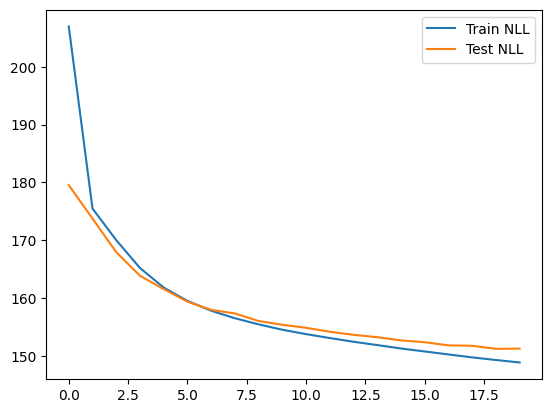

In [ ]:
test_key = random.PRNGKey(10)

epochs = range(n_epochs)
nlls_train = []
nlls_test = []
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step(epoch, training_generator, opt_state)
    nll_test = evaluate(opt_state, test_images, test_key)
    print(f"Train NLL: {nll_train}, Test NLL: ", nll_test, '\n')
    nlls_train.append(nll_train)
    nlls_test.append(nll_test)

plt.plot(epochs, nlls_train, label="Train NLL")
plt.plot(epochs, nlls_test, label="Test NLL")
plt.legend()
plt.show()


### Task 3: Experiments

Let's put the trained VAE to use by visulizing the latent space and sampling synthetic data. Complete the following code snippets to do so.
**Visualize the latent space. Use the labels $y$ to color the latent representations in a scatter plot.**

Hint: Encode the training or test set, and use `plt.scatter`.

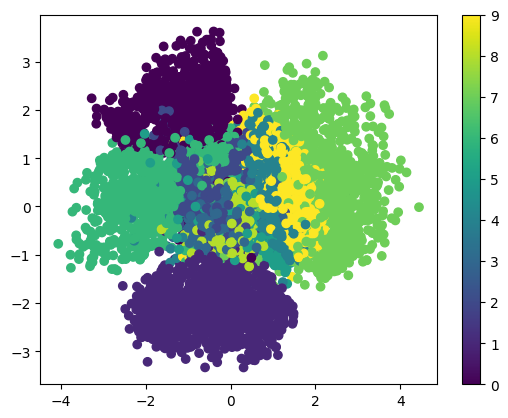

In [ ]:
def show_latent_space():
    x = jax.device_put(test_images) / 255.0
    params = get_params(opt_state)[0]
    phi = encode(params, inputs=x)
    z = sample(test_key, mu=phi[0], std=phi[1])

    plt.scatter(z[:, 0], z[:, 1], c=test_labels)
    plt.colorbar()
    plt.show()

show_latent_space()

Monitor the reconstruction quality of your model. Visualize a single input image together its reconstruction.

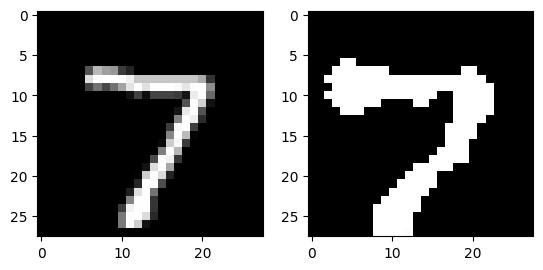

In [ ]:
def reconstruct_an_image():
  x = test_images[0]
  params = get_params(opt_state)
  (mu, sigma), z, bernoulli_theta = forward(params, x.flatten(), test_key)
  bernoulli_theta = jax.nn.sigmoid(bernoulli_theta).reshape(28, 28)

  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(x.reshape(28, 28), cmap='gray')
  axes[1].imshow(bernoulli_theta, cmap='gray')
  plt.show()

reconstruct_an_image()

**Generate synthetic data.** Hint: sample $z\sim p(z)$ or "walk" in the latent space. Decode the $z$ you sample/visit and plot the decoded image. Think about what output you expect when you sample from 1) a Bernoulli distribution, or 2) regard the Bernoulli parameter as the sample.

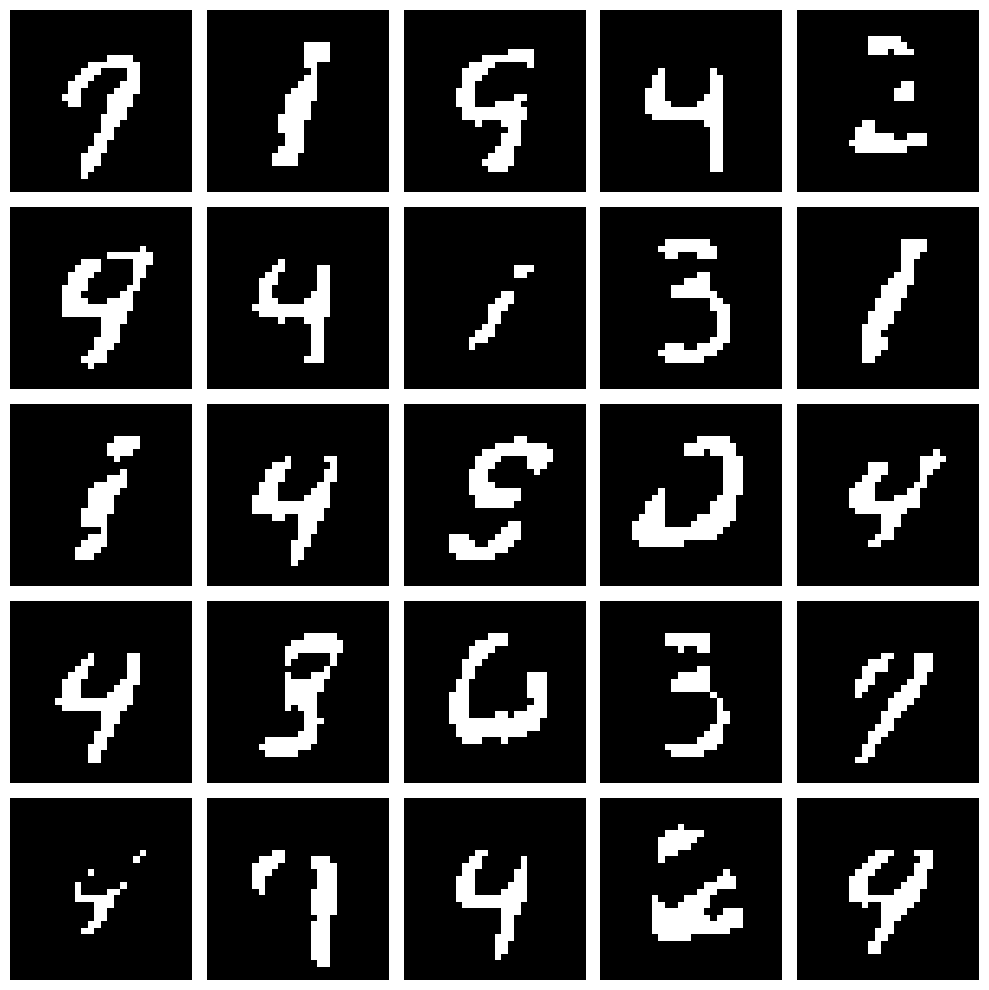

In [ ]:
def sample_image(d_params, num_samples=25):

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Create a 5x5 grid of subplots
    rng = random.PRNGKey(42)  # Seed for reproducibility
    for i, ax in enumerate(axes.flat):  # Iterate over subplots
        if i < num_samples:
            rng, subkey = random.split(rng)  # Split the random key for each sample
            z = random.normal(subkey, (latent_dimensions,))  # Sample latent vector
            bernoulli_theta = decode(d_params, z)  # Decode to logits
            sampled_image = round(bernoulli_theta).reshape(28, 28)  # Convert logits to probabilities
            ax.imshow(sampled_image, cmap='gray')  # Display image in the subplot
            ax.axis('off')  # Turn off subplot axes

    plt.tight_layout()
    plt.show()

decoder_params = get_params(opt_state)[1]
sample_image(decoder_params)

## $\beta$-VAE

The $\beta$-VAE was proposed by [Higgins et al.](https://openreview.net/pdf?id=Sy2fzU9gl) in 2017 and is a straightforward but important extension of the VAE. In terms of architecture, $\beta$-VAE and VAE are indistinguishable. In fact, the novelty in the work by Higgins et al. lies in a minor modification of the ELBO objective, the $\beta$-objective

$\mathcal{L}_\beta = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$,

where $\beta\geq0$ is a hyperparameter weighting the KL divergence

KL $ (q_\phi(z|x)\Vert p(z)) = \mathbb{E}_{q_\phi(z|x)}[ \log \frac{q_\phi(z|x)}{p(z)}]$.

Observe that we retrieve the standard ELBO when $\beta=1$.

This objective is useful for

* emphasizing high-fidelity reconstructions *or* disentangling the latent space
* obtaining an increased interpretability
* doing KL warm-up.

The effects of the $\beta$-objective are mostly visible asymptotically, why we may not experience the full power of it here (e.g., [NVAE](https://arxiv.org/pdf/2007.03898.pdf) applies KL warm-up during the *first 25k iterations*).

However, plenty of the state-of-the-art VAEs (in terms of density estimation) apply KL warm-up (e.g. NVAE, [VampPrior](https://arxiv.org/pdf/1705.07120.pdf), [LadderVAE](https://arxiv.org/pdf/1602.02282.pdf); see LadderVAE for a nice motivation of KL warm-up), so it is good to know. Also, aside from being very straightforward to implement, the $\beta$-objective leads us to the following important note.

**Important note**: as pointed out by [Hoffman et al.](http://bayesiandeeplearning.org/2017/papers/66.pdf), the $\beta$-objective shown above cannot be considered an evidence lower-bound. Hence, test scores based on the $\beta$-objective **should not be used for benchmarking against proper marginal log-likelihood estimates (such as the ELBO)**. If you are interested, try to reverse the derivations of the ELBO in [1] while including $\beta$.

### Task 4: $\beta$-ELBO

**Compute the $\beta$-objective in the following function.**

Hint: this should require minimal changes to the ```get_elbo```
function above. Also, observe that



$\mathcal{L}_\beta \simeq \frac{1}{L}\sum_l \log p_\theta(x|z_l)-\beta\log\frac{q_\phi(z_l|x)}{p(z_l)}$.


In [ ]:
@jit
def get_beta_elbo(params, x, rng, beta):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward(params, x, rng)

    log_p_x_given_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=-1)
    log_p_z = tfp.distributions.Normal(loc=jnp.zeros_like(mu), scale=jnp.ones_like(sigma)).log_prob(z).sum(axis=-1)
    log_q_z_given_x = tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(z).sum(axis=-1)

    beta_elbo = jnp.mean(log_p_x_given_z - beta * (log_q_z_given_x - log_p_z))
    return -beta_elbo

Now we define ```epoch_step_beta``` that calls ```get_beta_elbo``` instead of ```get_elbo```, and so that it can take a $\beta\geq 0$ as input.

In [ ]:
def epoch_step_beta(epoch, training_generator, opt_state, beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_beta_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         beta)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

Again, importantly, we have used $\beta=1$ as default in ```evaluate_beta```, which makes the evaluation scores comparable to those of the standard VAE that we trained above.

In [ ]:
def evaluate_beta(opt_state, x, test_rng,beta=1):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255
    nll = get_beta_elbo(params,
                        x,
                        test_rng,beta)
    return nll

Before retraining the VAE, or $\beta$-VAE, we need to reinitialize the encoder/decoder nets and the optimizer above. This is done by simply running the cell below.

In [ ]:
beta = 1.5
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

Rerun the experiments section below. Any difference? If you train for a few couple of epochs, then we shouldn't expect huge variations. But perhaps setting $\beta$ to something very big will affect the distribution of $z$'s in the latent space? Does setting $\beta=0$ affect the fidelity of the reconstructed image? Why would we, at least asymptotically, expect these effects?

### Task 4: $\beta$-Experiments

In [ ]:
train_key,test_key = random.split(random.PRNGKey(10))
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_beta(epoch,
                                           training_generator,
                                           opt_state,
                                           beta)
    nll_test = evaluate_beta(opt_state,
                             test_images,
                             test_key)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:17<00:00, 14.21it/s]


Train NLL:  210.58174
Test NLL:  181.29312
Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 15.11it/s]


Train NLL:  178.50381
Test NLL:  174.09634
Epoch:  2


100%|██████████| 242/242 [00:17<00:00, 13.74it/s]


Train NLL:  172.46603
Test NLL:  168.69145
Epoch:  3


100%|██████████| 242/242 [00:15<00:00, 15.38it/s]


Train NLL:  168.46432
Test NLL:  165.50845
Epoch:  4


100%|██████████| 242/242 [00:15<00:00, 15.35it/s]


Train NLL:  165.97995
Test NLL:  163.96661
Epoch:  5


100%|██████████| 242/242 [00:15<00:00, 15.24it/s]


Train NLL:  164.18024
Test NLL:  161.83353
Epoch:  6


100%|██████████| 242/242 [00:16<00:00, 14.86it/s]


Train NLL:  162.7897
Test NLL:  160.81308
Epoch:  7


100%|██████████| 242/242 [00:16<00:00, 15.11it/s]


Train NLL:  161.67804
Test NLL:  160.00714
Epoch:  8


100%|██████████| 242/242 [00:15<00:00, 15.34it/s]


Train NLL:  160.79765
Test NLL:  159.44066
Epoch:  9


100%|██████████| 242/242 [00:16<00:00, 14.76it/s]


Train NLL:  159.99564
Test NLL:  158.45287
Epoch:  10


100%|██████████| 242/242 [00:16<00:00, 14.69it/s]


Train NLL:  159.34308
Test NLL:  157.93196
Epoch:  11


100%|██████████| 242/242 [00:15<00:00, 15.37it/s]


Train NLL:  158.62178
Test NLL:  157.13911
Epoch:  12


100%|██████████| 242/242 [00:15<00:00, 15.39it/s]


Train NLL:  158.19608
Test NLL:  156.56165
Epoch:  13


100%|██████████| 242/242 [00:16<00:00, 14.75it/s]


Train NLL:  157.58044
Test NLL:  156.19284
Epoch:  14


100%|██████████| 242/242 [00:15<00:00, 15.25it/s]


Train NLL:  157.003
Test NLL:  156.10152
Epoch:  15


100%|██████████| 242/242 [00:15<00:00, 15.31it/s]


Train NLL:  156.59747
Test NLL:  155.58952
Epoch:  16


100%|██████████| 242/242 [00:15<00:00, 15.36it/s]


Train NLL:  156.11134
Test NLL:  154.7416
Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 13.78it/s]


Train NLL:  155.5578
Test NLL:  154.34178
Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 15.08it/s]


Train NLL:  155.11685
Test NLL:  154.11943
Epoch:  19


100%|██████████| 242/242 [00:16<00:00, 14.88it/s]

Train NLL:  154.78305
Test NLL:  153.6262


What has changed in the latent space? Try playing with a few values of $\beta$ and explain what affects the change in the latent space?

**The $\beta$ term allowed to disentangle the latent space, now we can see better separation between the classes. This is because the $\beta$ term penalizes the KL divergence term in the ELBO, which in turn forces the latent space to be more similar to the prior distribution.**

**For greater $\beta$ values, the latent space will be more similar to the prior distribution, and the latent space will be more disentangled.**

**For smaller $\beta$ values, the latent space will be more similar to the posterior distribution, and the latent space will be less disentangled.**

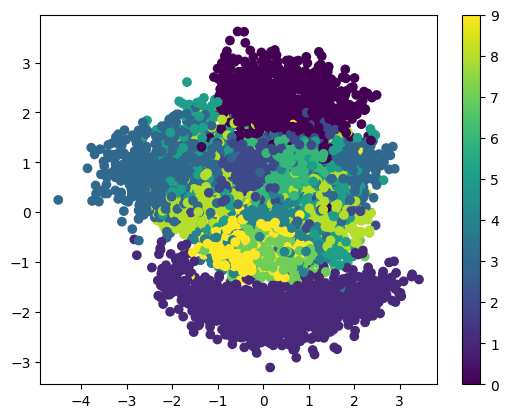

In [ ]:
# visualize the latent space

def show_latent_space():
    x = jax.device_put(test_images) / 255.0
    params = get_params(opt_state)[0]
    phi = encode(params, inputs=x)
    z = sample(test_key, mu=phi[0], std=phi[1])

    plt.scatter(z[:, 0], z[:, 1], c=test_labels)
    plt.colorbar()
    plt.show()

show_latent_space()

What about the reconstruction quality of your model? Has it improved or degraded?

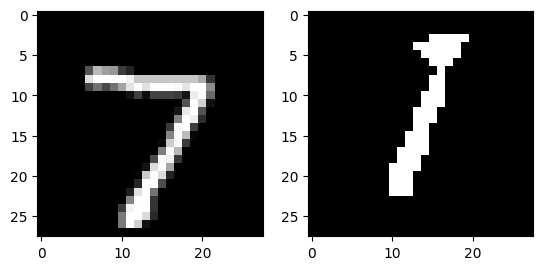

In [ ]:
# reconstruct an image

def reconstruct_an_image():
  x = test_images[0]
  params = get_params(opt_state)
  (mu, sigma), z, bernoulli_theta = forward(params, x.flatten(), test_key)
  bernoulli_theta = round(bernoulli_theta).reshape(28, 28)

  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(x.reshape(28, 28), cmap='gray')
  axes[1].imshow(bernoulli_theta, cmap='gray')
  plt.show()

reconstruct_an_image()

Sample from the latent space and decode. Do you see any difference?

**Improved a little bit, we can see more clearly a number, though it is not perfect.**

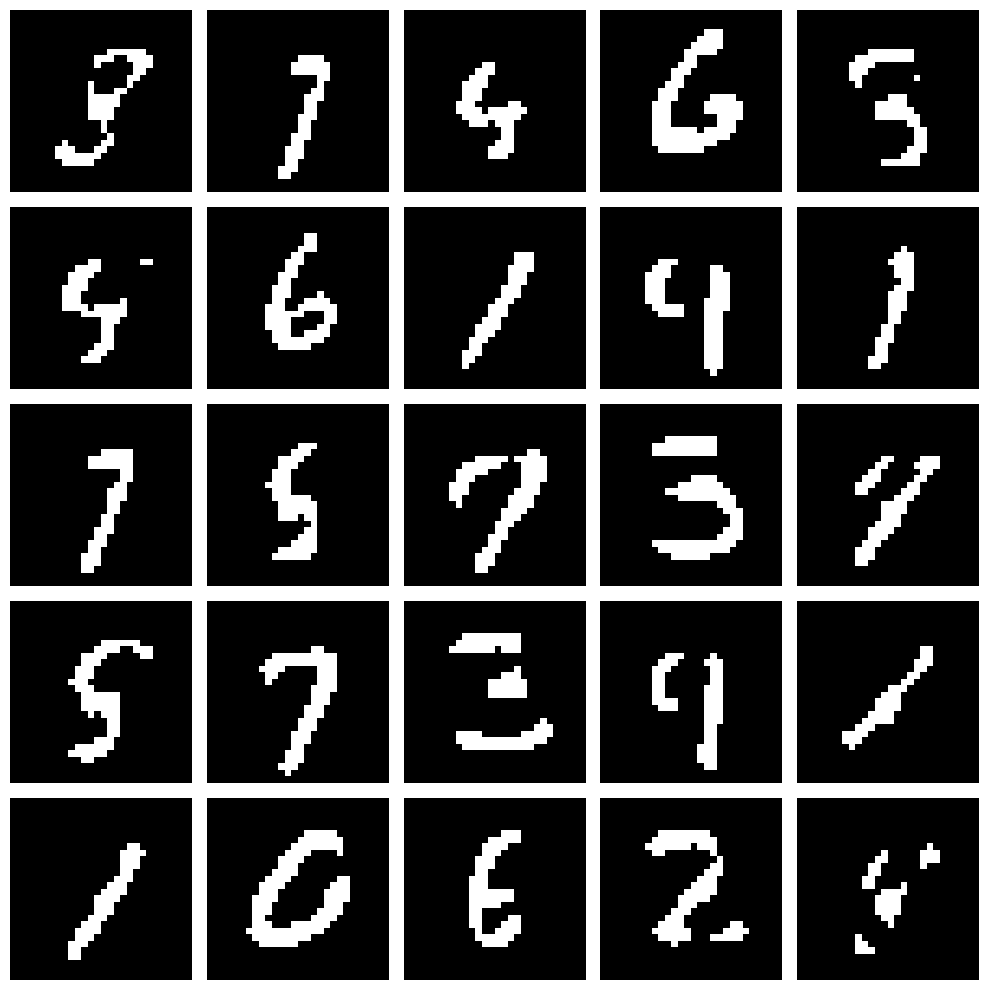

In [ ]:
def sample_image(d_params, num_samples=25):

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Create a 5x5 grid of subplots
    rng = random.PRNGKey(42)  # Seed for reproducibility
    for i, ax in enumerate(axes.flat):  # Iterate over subplots
        if i < num_samples:
            rng, subkey = random.split(rng)  # Split the random key for each sample
            z = random.normal(subkey, (latent_dimensions,))  # Sample latent vector
            bernoulli_theta = decode(d_params, z)  # Decode to logits
            sampled_image = round(bernoulli_theta).reshape(28, 28)  # Convert logits to probabilities
            ax.imshow(sampled_image, cmap='gray')  # Display image in the subplot
            ax.axis('off')  # Turn off subplot axes

    plt.tight_layout()
    plt.show()

decoder_params = get_params(opt_state)[1]
sample_image(decoder_params)

## Importance Weigthed Auto-Encoder (IWAE)


Similarily as for $\beta$-VAE, the distinguishing factor between the VAE and [IWAE](https://arxiv.org/abs/1509.00519) is the alternative objective function, the importance weighted ELBO (IWELBO):

$\mathcal{L}_{K} = \mathbb{E}_{q_\phi(z|x)}\left[\log\frac{1}{K}\sum_k\frac{p_\theta(x|z_k)p(z_k)}{q_\phi(z_k|x)}\right]$.

When computing $\mathcal{L}_{K}$ in contrast to the ELBO, we sample $K$ latent representations instead of one. Although this might seem like a simple extension, the IWELBO has huge implications on the field of VAEs, *as well as* the VI literature in general (see e.g. [Domke and Sheldon](https://arxiv.org/pdf/1808.09034.pdf)). Specifically (n.b., *not an exhaustive list*),

* it is a proper lower-bound on the marginal log-likelihood.
* it is an effective way of improving the NLL test scores (used by state-of-the-art VAEs when reporting NLL scores, including those mentioned above).

The former bullet implies that we *can* use IWELBO to benchmark our VAE against other VAEs, in contrast to the $\beta$-objective. The latter bullet implies that we probably *should* use it when benchmarking. Because, accoring to  Theorem 1 in the IWAE paper, the marginal log-likelihood estimates are montonically increasing with $K$, meaning that

$\mathcal{L}_{K}\geq \mathcal{L}_{K-1}\geq \mathcal{L}$.

### Task 5: IWELBO

Modify the following functions such that $K$ samples are drawn instead of 1. Then compute the IWELBO.

In [ ]:
def sample_K(rng, mu, std, K):
  epsilon = random.normal(rng, shape=(K,)+mu.shape)
  z = mu[None, ...] + std[None, ...] * epsilon
  return z

In [ ]:
@partial(jax.jit, static_argnames=['K'])
def forward_K(params, x, rng, K):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample_K(rng,
            mu=phi[0],
            std=phi[1],
            K=K)
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

In [ ]:
from jax.scipy.special import logsumexp

def get_iw_elbo(params, x, rng, K):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward_K(params, x, rng, K)

    log_p_x_given_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=-1)
    log_p_z = tfp.distributions.Normal(loc=jnp.zeros_like(mu), scale=jnp.ones_like(sigma)).log_prob(z).sum(axis=-1)
    log_q_z_given_x = tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(z).sum(axis=-1)

    iw_elbo = logsumexp((log_p_x_given_z - (log_q_z_given_x - log_p_z)), axis=0) - jnp.log(K)
    iw_elbo = jnp.mean(iw_elbo)

    return -iw_elbo

In [ ]:
def epoch_step_K(epoch, training_generator, opt_state,beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_iw_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         K)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

In [ ]:
def evaluate_K(opt_state, x, test_rng, K):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    params, x = jax.lax.stop_gradient(params), jax.lax.stop_gradient(x)
    nll = get_iw_elbo(params, x, test_rng, K)
    return nll

Again, we need to re-initialize the network and optimizer states.

In [ ]:
K = 4  # try with different values ranging from 1 to 10
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)  # this time we use a smaller learning rate due to numerical stability
opt_state = opt_init(params)

In [ ]:
test_key = random.PRNGKey(10)
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_K(epoch,
                                      training_generator,
                                      opt_state,
                                      K)
    nll_test = evaluate_K(opt_state, test_images, test_key, K)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:30<00:00,  7.94it/s]


Train NLL:  298.66696
Test NLL:  213.18849
Epoch:  1


100%|██████████| 242/242 [00:27<00:00,  8.85it/s]


Train NLL:  207.94157
Test NLL:  200.50647
Epoch:  2


100%|██████████| 242/242 [00:27<00:00,  8.75it/s]


Train NLL:  197.42511
Test NLL:  193.64442
Epoch:  3


100%|██████████| 242/242 [00:27<00:00,  8.68it/s]


Train NLL:  192.41866
Test NLL:  190.25015
Epoch:  4


100%|██████████| 242/242 [00:29<00:00,  8.30it/s]


Train NLL:  189.6765
Test NLL:  188.01564
Epoch:  5


100%|██████████| 242/242 [00:27<00:00,  8.67it/s]


Train NLL:  187.77484
Test NLL:  186.50497
Epoch:  6


100%|██████████| 242/242 [00:27<00:00,  8.80it/s]


Train NLL:  186.49669
Test NLL:  185.31737
Epoch:  7


100%|██████████| 242/242 [00:27<00:00,  8.73it/s]


Train NLL:  185.40244
Test NLL:  184.24753
Epoch:  8


100%|██████████| 242/242 [00:27<00:00,  8.87it/s]


Train NLL:  184.37724
Test NLL:  183.17729
Epoch:  9


100%|██████████| 242/242 [00:28<00:00,  8.53it/s]


Train NLL:  183.19737
Test NLL:  181.89209
Epoch:  10


100%|██████████| 242/242 [00:28<00:00,  8.64it/s]


Train NLL:  181.88344
Test NLL:  180.28174
Epoch:  11


100%|██████████| 242/242 [00:27<00:00,  8.85it/s]


Train NLL:  180.22246
Test NLL:  178.57027
Epoch:  12


100%|██████████| 242/242 [00:28<00:00,  8.53it/s]


Train NLL:  178.68436
Test NLL:  177.09212
Epoch:  13


100%|██████████| 242/242 [00:27<00:00,  8.75it/s]


Train NLL:  177.3596
Test NLL:  175.93689
Epoch:  14


100%|██████████| 242/242 [00:27<00:00,  8.76it/s]


Train NLL:  176.26265
Test NLL:  175.00702
Epoch:  15


100%|██████████| 242/242 [00:28<00:00,  8.55it/s]


Train NLL:  175.3096
Test NLL:  174.24612
Epoch:  16


100%|██████████| 242/242 [00:27<00:00,  8.79it/s]


Train NLL:  174.52165
Test NLL:  173.61046
Epoch:  17


100%|██████████| 242/242 [00:27<00:00,  8.71it/s]


Train NLL:  173.88791
Test NLL:  173.03525
Epoch:  18


100%|██████████| 242/242 [00:27<00:00,  8.73it/s]


Train NLL:  173.3389
Test NLL:  172.54369
Epoch:  19


100%|██████████| 242/242 [00:27<00:00,  8.69it/s]


Train NLL:  172.80894
Test NLL:  172.10686


Plot your NLL test scores as a function of $K$ for $K \in \{1,\dots,10\}$, and see if there is any improvement in NLL as K increases.

**We can see that the NLL score decreases as K increases, which is expected as the IWAE is a proper lower bound on the marginal log-likelihood.**

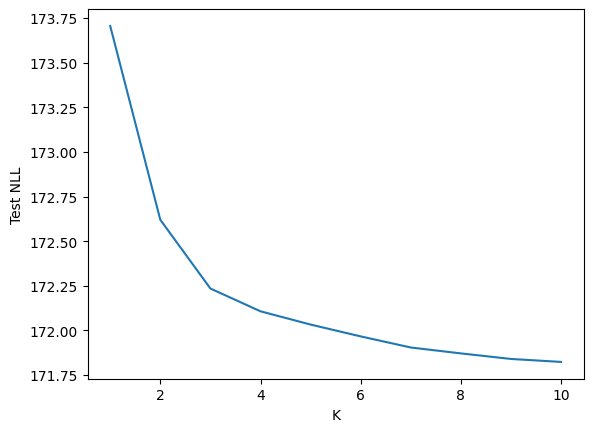

In [ ]:
def plot_test_nll_vs_k():
  nlls_test = []
  for K in range(1, 11):
    nll_test = evaluate_K(opt_state, test_images, test_key, K)
    nlls_test.append(nll_test)

  plt.plot(range(1, 11), nlls_test)
  plt.xlabel('K')
  plt.ylabel('Test NLL')
  plt.show()

nlls_test = plot_test_nll_vs_k()

Finally, it is valuable to know, how long did it take you to finish this practical?